In [28]:
%run 'pymol_and_pdb_functions.py'
start_pymol()

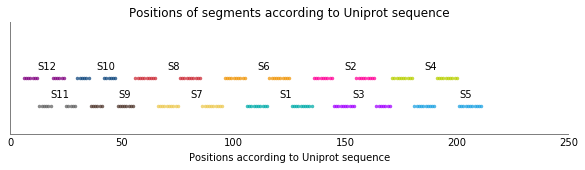

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


In [29]:
import itertools

%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks17'
image_counter = Counter()

### Reading 24-mer structure

In [55]:
his3_aligned_to_4lom_assembly_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 
                                                  'his3_swiss_aligned_to_4lom_assembly.pdb')
structure = Bio.PDB.PDBParser().get_structure('his3_swiss_assembly', his3_aligned_to_4lom_assembly_file)
model = structure[0]

### Calculating distances

In [56]:
distance_dict = OrderedDict()
prefix = 'res_'

constant_chain = model['A']

positions_in_crystal = [r.id[1] for r in constant_chain.get_residues() if r.get_resname() in aa3]

f = FloatProgress(min=0, max=len(list(constant_chain.get_residues())))
display(f)

for residue in constant_chain.get_residues():
    if residue.get_resname() in aa3:
        distance_dict[prefix + '%s' %residue.id[1]] = OrderedDict()

        # distances to other residues
        for position in positions_in_crystal:
            distances = []
            for other_chain in model.get_chains():
                distances.append(get_distance_between_residues(residue, other_chain[position]))
                break
            distance_dict[prefix + '%s' %residue.id[1]][prefix + '%s' %position] = min(distances)

        # distances to Mn ions
        for position in [302, 303, 304]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
                break
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '%s' %position] = min(distances)
        distance_dict[prefix + '%s' %residue.id[1]]['Mn_substrate_bound'] = min(
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '302'],
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '303'])
            
        # distances to substrate
        for position in [301]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
                break
            distance_dict[prefix + '%s' %residue.id[1]]['substrate'] = min(distances)
    f.value += 1

In [57]:
structural_data = pd.DataFrame.from_dict(distance_dict, orient='index')
new_index = sorted(structural_data.index.values, key=lambda s: int(s[4:]))
structural_data = structural_data.reindex(new_index)
structural_data['position'] = structural_data.index.map(lambda s: int(s[4:]))

### Secondary structure

In [ ]:
%run 'ks38_Read_secondary_structure'

In [58]:
structural_data['secondary_structure'] = structural_data['position'].apply(get_secondary_structure)

### Interface residues

### Sign epistasis from Lucas

In [59]:
# Relative >>> absolute position
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_number, relative_position):
    return int(position_translation.iloc[relative_position]['S'+str(segment_number)])

In [60]:
lucas_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_sign_epistasis.csv')
lucas_reciprocal_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_reciprocal_sign_epistasis.csv')

p_value_threshold = 0.01
filtered = lucas_sign_epistasis[lucas_sign_epistasis['pBon'] < p_value_threshold]
sign_epistasis_positions = set.union(set(filtered['VarPos_absolute'].values), 
                                                set(filtered['SubPos_absolute'].values))
sign_epistasis_positions = sorted([int(s) for s in sign_epistasis_positions])
print len(sign_epistasis_positions), 'positions under sign epistasis'

reciprocal_sign_epistasis_positions = set.union(set(lucas_reciprocal_sign_epistasis['position1'].values), 
                                                set(lucas_reciprocal_sign_epistasis['position1'].values))
reciprocal_sign_epistasis_positions = sorted([int(s) for s in reciprocal_sign_epistasis_positions])
print len(reciprocal_sign_epistasis_positions), 'positions under reciprocal sign epistasis'

structural_data['lucas_sign_epistasis'] = structural_data.index.map(lambda s: int(s[4:]) in sign_epistasis_positions)
structural_data['lucas_reciprocal_sign_epistasis'] = structural_data.index.map(lambda s: int(s[4:]) in reciprocal_sign_epistasis_positions)

94 positions under sign epistasis
59 positions under reciprocal sign epistasis


In [61]:
all_positions = set(lucas_sign_epistasis.VarPos_absolute.values)
sign_positions = set(lucas_sign_epistasis[lucas_sign_epistasis.pBon < 0.01].VarPos_absolute.values)
no_sign_positions = all_positions.copy()
no_sign_positions.difference_update(sign_positions)
print 'sign_positions', sorted(list(sign_positions))
print 'no_sign_positions', sorted(list(no_sign_positions))

sign_positions [7, 8, 9, 11, 13, 16, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 38, 41, 56, 60, 62, 76, 77, 78, 79, 80, 81, 82, 85, 96, 97, 98, 99, 102, 104, 105, 106, 108, 110, 111, 112, 114, 115, 117, 119, 120, 121, 122, 131, 135, 137, 139, 140, 141, 142, 143, 144, 145, 147, 148, 151, 152, 154, 157, 160, 161, 163, 164, 165, 168, 169, 170, 172, 175, 177, 181, 189, 202, 203, 206, 207, 208, 209]
no_sign_positions [19, 21, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 42, 43, 45, 47, 48, 49, 50, 52, 53, 54, 55, 59, 66, 67, 73, 86, 87, 92, 93, 171, 173, 178, 180, 183, 195, 196, 198, 200, 201, 204, 205, 210, 211]


### Conservation score

In [62]:
Scer_Uniprot = open(os.path.join(files_dump_folder, 'HIS3_saccharomyces_cerevisiae_from_Uniprot_P06633.txt')).read().rstrip()

# numbering starts from zero
conservation_scores = pd.read_table(files_dump_folder + 'conservation_score.csv')
conservation_scores['positions_Uniprot_P06633'] = conservation_scores.position_in_alignment.apply(
    lambda p: get_wt_position(p))

structural_data['segment'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['segment'])
structural_data['Scer_aa'] = structural_data['position'].apply(lambda p: Scer_Uniprot[p-1])

structural_data['alignment_entropy'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['entropy'])
structural_data['alignment_gap_fraction'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['gap_fr'])
structural_data['conservation_score'] = structural_data['position'].apply(lambda p: conservation_scores.iloc[p-1]['score'])

### Amino acid properties

In [20]:
aa_properties = pd.read_csv(files_dump_folder + 'properties_of_amino_acids.csv')
structural_data = structural_data.reset_index().merge(aa_properties, left_on='Scer_aa' ,right_on='aa1', how='left').set_index('index')

### Impacts of mutations

In [21]:
def read_impacts_in_all_backgrounds(path_to_folder=None):
    if not path_to_folder:
        path_to_folder = os.path.join(files_dump_folder, 'impacts_of_mutations_in_all_backgrounds__full_lib', '')
        print 'Since path to folder with hdfs was not provided, this is the path that will be used:\n%s' %path_to_folder

    progress_bar = FloatProgress(min=0, max=len(data.keys()))
    display(progress_bar)

    fit_dict = OrderedDict()
    for segment in data:
        segment_folder = os.path.join(path_to_folder, segment.split('_')[0], '')
        files = [f for f in os.listdir(segment_folder)]
        data_subset = data[segment].copy() 
        mutations = list(set(':'.join(data_subset.dropna(subset=['mut_list_Scer']).mut_list_Scer.values).split(':')))
        mutations = sorted(list(mutations), key=lambda m: int(m[:-1]))
        for mutation in mutations:
            fn = 'impacts_of_mutation_%s.hdf' %(mutation)
            if fn in files:
                fit_dict[get_full_mutation(mutation)] = pd.read_hdf(segment_folder + fn)
        progress_bar.value += 1
    return fit_dict

folder_with_fitness_impacts = check_dir(os.path.join(files_dump_folder, 'impacts_of_mutations_in_all_backgrounds', ''))
fit_dict = read_impacts_in_all_backgrounds(path_to_folder=folder_with_fitness_impacts)

In [26]:
structural_data

,res_2,res_3,res_4,res_5,res_6,res_7,res_8,res_9,res_10,res_11,...,"Occurrence in proteins, %_y","Average volume of buried residues, A3_y","Van der Waals volume, A3_y","Accessible surface area, A2_y",Fraction of buried among this aa_y,Fraction of buried among all buried_y,Polarity average ranking_y,Polarity ranking (Radzicka and Wolfenden 1988)_y,aa1_y,aa3_y
index,,,,,,,,,,,,,,,,,,,,,
res_2,0.000000,1.344903,3.929120,6.801780,10.320789,12.860404,16.926117,20.202641,23.694307,27.035435,...,6.0,122.0,93.0,102.0,25.0,5.5,12.0,11.0,T,THR
res_3,1.344903,0.000000,1.335484,2.674407,7.090796,9.983333,13.894839,17.330608,20.780022,24.223778,...,6.3,155.0,109.0,138.0,20.0,2.0,18.0,17.0,E,GLU
res_4,3.929120,1.335484,0.000000,1.344155,4.498135,8.109940,11.214881,14.755608,17.634836,21.506519,...,4.1,161.0,114.0,144.0,6.3,2.2,17.0,14.0,Q,GLN
res_5,6.801780,2.674407,1.344155,0.000000,1.344352,4.719050,8.127696,11.605848,15.022046,18.489553,...,5.8,171.0,135.0,167.0,4.2,0.1,20.0,15.0,K,LYS
res_6,10.320789,7.090796,4.498135,1.344352,0.000000,1.345744,4.493712,8.010320,11.393576,14.883163,...,7.5,92.0,67.0,67.0,38.0,12.0,9.0,7.0,A,ALA
res_7,12.860404,9.983333,8.109940,4.719050,1.345744,0.000000,1.339997,4.493738,7.964891,11.392092,...,9.1,168.0,124.0,137.0,41.0,10.0,3.0,1.0,L,LEU
res_8,16.926117,13.894839,11.214881,8.127696,4.493712,1.339997,0.000000,1.346331,4.322484,7.995336,...,6.5,142.0,105.0,117.0,56.0,15.0,4.0,3.0,V,VAL
res_9,20.202641,17.330608,14.755608,11.605848,8.010320,4.493738,1.346331,0.000000,1.340466,4.455739,...,5.8,171.0,135.0,167.0,4.2,0.1,20.0,15.0,K,LYS
res_10,23.694307,20.780022,17.634836,15.022046,11.393576,7.964891,4.322484,1.340466,0.000000,1.344090,...,5.2,225.0,148.0,196.0,0.0,0.0,15.0,19.0,R,ARG


In [25]:
fitness_impacts = pd.DataFrame.from_dict(fit_dict, orient='index')
fitness_impacts['position'] = fitness_impacts.index.map(lambda s: int(s[1:-1]))
fitness_impacts['impact_mean'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().mean())
fitness_impacts['impact_median'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().median())
fitness_impacts['impact_std'] = fitness_impacts.index.map(lambda m: fitness_impacts.loc[m].dropna().std())

KeyboardInterrupt: 

In [ ]:
impacts_summary = fitness_impacts.groupby('position')['impact_median'].agg([np.mean, np.median, np.std])
impacts_summary.columns = ['impact_' + s for s in impacts_summary.columns]
structural_data = structural_data.reset_index().merge(impacts_summary, how='left', left_on='position', right_index=True)
structural_data = structural_data.set_index('index')

### Epistasis

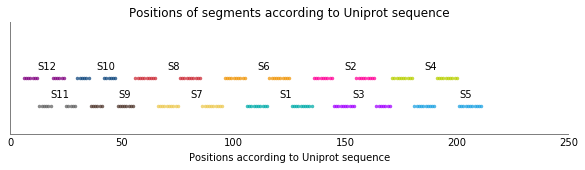

1886 unique mutations across all segments
238 natural unique mutations across all segments
There are 231 single mutations with known effects. They are found in 120 positions


In [23]:
%run 'ks08_Epistasis_in_all_backgrounds.ipynb'

In [24]:
def get_empty_segment_position1_position2_defaultdict(segment_mutA_mutB_dict):
    epistasis_by_positions = OrderedDict()
    for segment in segment_mutA_mutB_dict:
#         epistasis_by_positions[segment] = OrderedDict()
        mutA_positions = set(mutA[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        mutB_positions = set(mutB[:-1] for mutA, mutB in segment_mutA_mutB_dict[segment])
        all_positions = sorted(list(set.union(mutA_positions, mutB_positions)), key=lambda s: int(s))
        for position1 in all_positions:
            epistasis_by_positions[position1] = OrderedDict()
            for position2 in all_positions:
                if position1 != position2:
                    epistasis_by_positions[position1][position2] = defaultdict(list)
    return epistasis_by_positions

def fill_dictionary_with_values(dict_to_fill, segment_mutA_mutB_dict):
    for segment in segment_mutA_mutB_dict:
        for mutA, mutB in segment_mutA_mutB_dict[segment]:
            posA, posB = mutA[:-1], mutB[:-1]
            ep = segment_mutA_mutB_dict[segment][mutA, mutB]

            if len(ep) > minimal_N:    
                std = ep.std()
                mean = ep.mean()
                median = ep.median()
                fraction_strong = 1. * len(ep[np.abs(ep) > strong_epistasis_threshold]) / len(ep)

                dict_to_fill[posA][posB]['std'].append(std)
                dict_to_fill[posB][posA]['std'].append(std)
                
                dict_to_fill[posA][posB]['mean'].append(mean)
                dict_to_fill[posB][posA]['mean'].append(mean)

                dict_to_fill[posA][posB]['median'].append(median)
                dict_to_fill[posB][posA]['median'].append(median)

                dict_to_fill[posA][posB]['fraction_strong'].append(fraction_strong)
                dict_to_fill[posB][posA]['fraction_strong'].append(fraction_strong)
                
    return dict_to_fill

def filter_position1_position2_dict(position1_position2_dict, what_to_look_at):
    filtered = {}
    for position in position1_position2_dict:
        other_positions = position1_position2_dict[position].keys()
        other_positions = [p for p in other_positions if len(position1_position2_dict[position][p][what_to_look_at]) > 0]
        values = [np.mean(position1_position2_dict[position][p][what_to_look_at]) for p in other_positions \
                  if len(position1_position2_dict[position][p][what_to_look_at]) > 0]
        filtered[position] = other_positions, values
    return filtered

In [ ]:
epdict__pos1_pos2 = get_empty_segment_position1_position2_defaultdict(ep_dict)
epdict__pos1_pos2 = fill_dictionary_with_values(epdict__pos1_pos2, ep_dict)

In [ ]:
ep_mean_prefix = 'ep_mean_res_'

def get_ep_slice(dict__pos1_pos2, function, ep_prefix):
    d = {}
    for position1 in dict__pos1_pos2:
        for position2 in dict__pos1_pos2[position1]:
            d[prefix + '%s' %position1] = {}
            d[prefix + '%s' %position2] = {}

    for position1 in dict__pos1_pos2:
        for position2 in dict__pos1_pos2[position1]:
            d[prefix + '%s' %position1][ep_prefix + '%s' %position2] = function(dict__pos1_pos2[position1][position2]['median'])
            d[prefix + '%s' %position2][ep_prefix + '%s' %position1] = function(dict__pos1_pos2[position1][position2]['median'])
    df = pd.DataFrame.from_dict(d, orient='index')
    sorted_columns = sorted(df.columns, key=lambda s: int(s[len(ep_prefix):]))
    df['position'] = df.index.map(lambda s: int(s[len(prefix):]))
    return df

structural_data = structural_data.reset_index().merge(get_ep_slice(epdict__pos1_pos2, np.mean, ep_mean_prefix), on='position', how='left')
structural_data = structural_data.set_index('index')

In [ ]:
title = 'Distance vs epistasis'
plot_better()
for position in structural_data1['position']:
    try:
        plt.scatter(structural_data1[prefix + '%s' %position], structural_data1[ep_mean_prefix + '%s' %position], 
                    edgecolor='none', color='purple', alpha=0.1)
    except:
        pass
plt.ylim(-0.05, 0.05)
plt.xlabel('Distance between positions, A')
plt.ylabel('Average epistasis between positions\nin all backgrounds')

### ddG

In [63]:
rosetta_folder = os.path.join(analysis_folder, 'Sasha', 'rosetta_runs', '')
predicted_ddG = pd.read_table(rosetta_folder + 'run-170503-results-with-explicit-ddG.csv')
predicted_ddG['mut_number'] = predicted_ddG['mut_list_Scer'].apply(lambda s: s.count(':')+1)
predicted_ddG['mut_list_Scer_full'] = predicted_ddG['mut_list_Scer'].apply(convert_to_full_mutations)
for aa_property in quantitative_properties:
        predicted_ddG['Abs change in ' + aa_property.lower()] = predicted_ddG['mut_list_Scer_full'].apply(
            lambda mut_comb: cumulative_property_change(mut_comb, aa_property))

predicted_doubles = predicted_ddG[predicted_ddG['mut_number'] == 2].copy()
predicted_singles = predicted_ddG[predicted_ddG['mut_number'] == 1].copy()

In [64]:
predicted_singles['position'] = predicted_singles['mut_list_Scer'].apply(lambda m: int(m[:-1]))
mean_ddG = pd.DataFrame(predicted_singles.groupby('position')['ddG'].agg(np.mean))
mean_ddG.columns = ['ddG_mean']

var_ddG = pd.DataFrame(predicted_singles.groupby('position')['ddG'].agg(np.var))
var_ddG.columns = ['ddG_var']

structural_data = structural_data.reset_index().merge(mean_ddG, left_on='position', right_index=True, how='left')
structural_data = structural_data.set_index('index')

structural_data = structural_data.reset_index().merge(var_ddG, left_on='position', right_index=True, how='left')
structural_data = structural_data.set_index('index')

### Fitness potential

In [ ]:
residuals_folder = os.path.join(analysis_folder, 'Katya', 'NN', 'residuals', '')
fitness_potentials = OrderedDict()
for segment in data:
    fitness_potentials[segment] = pd.read_csv(residuals_folder + '%s.csv' %segment.split('_')[0])

### Saving files

In [ ]:
structural_data

In [66]:
structural_data.to_hdf(files_dump_folder + 'structural_data_for_monomer.hdf', 'data')
structural_data.reset_index().to_csv(files_dump_folder + 'structural_data_for_monomer.csv', index=False)